Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

Загрузим данные.

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/autos.csv')

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


1. В данных присутвуют пропуски в категориальных признаках (таких как тип топлива, модель автомобиля, тип коробки передач и тд).
2. Данные о датах имеют два различных формата (год и месяц регистраци являются разными признаками)

Посмотрим данные по годам регистрации автомобилей.

In [4]:
data['RegistrationYear'].value_counts().sort_values(ascending =True).head(20)

8455    1
1200    1
1400    1
3500    1
3700    1
4100    1
9996    1
9229    1
9450    1
8200    1
1039    1
2066    1
8500    1
1602    1
2290    1
6500    1
7500    1
5900    1
1001    1
2900    1
Name: RegistrationYear, dtype: int64

In [5]:
data['RegistrationYear'].describe(percentiles =[.025, .5, .975])

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
2.5%       1989.000000
50%        2003.000000
97.5%      2017.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

В данных присутвуют неверные значения, основное количество лежит в пределах (1989-2017). Используем промежуток 1988-2020.

In [6]:
data = data.query('1988<RegistrationYear<=2020')

Посмотрим данные по месяцам регистрации.

In [7]:
data['RegistrationMonth'].value_counts()

0     35474
3     33607
6     30807
4     28622
5     28533
7     26337
10    25721
12    23958
11    23853
9     23393
1     22521
8     22254
2     20833
Name: RegistrationMonth, dtype: int64

Есть большое количество значений равных нулю, для дальнейшего преобразования данных в формат datetime заменим нулевые значения месяцев на случайные числа в диапазоне от 1 до 12 включительно.

In [8]:
import numpy as np
from random import randint

data.loc[data['RegistrationMonth'] == 0,'RegistrationMonth'] = np.random.randint(1,13, size=len(data.loc[data['RegistrationMonth'] == 0]))

Переведем данные о датай к формату datetime, допустим что регистрациия всегда была первого числа.

In [9]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['LastSeen'] = pd.to_datetime(data['LastSeen'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['registrationday'] = 1
data['registrationdate'] = pd.to_datetime(dict(year=data.RegistrationYear, month=data.RegistrationMonth, day=data.registrationday))

#приведем названия столбцов к нижнему регистру
data.columns = map(str.lower, data.columns)

Проверим данные о ценах на автомобили.

In [10]:
data['price'].describe(percentiles =[.05, .5, .95])

count    345913.000000
mean       4400.939566
std        4500.387841
min           0.000000
5%          200.000000
50%        2700.000000
95%       14500.000000
max       20000.000000
Name: price, dtype: float64

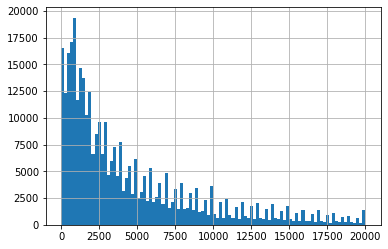

In [11]:
data['price'].hist(bins = 100)

Распределение близко к распределению Пауссона, при этом присутвуют объявления с нулевой ценой.

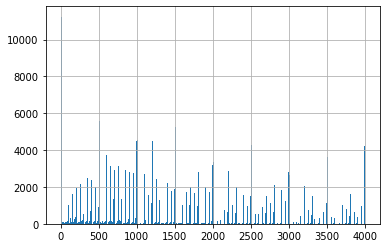

In [12]:
data['price'].hist(bins = 400, range =(0,4000))

Используем интервал от 200 до 14 500.

In [13]:
data = data.query('199<price<=14500')

Уберем признаки, которые не влияют на стоимость машины (такие как дата последней активности пользователя, почтовый индекс).

In [14]:
#так же уберем отдельные столбцы с датами регистрации
data = data.drop(columns=['lastseen','registrationday','registrationmonth','registrationyear', 'postalcode'])

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312225 entries, 0 to 354368
Data columns (total 13 columns):
datecrawled         312225 non-null datetime64[ns]
price               312225 non-null int64
vehicletype         282081 non-null object
gearbox             297846 non-null object
power               312225 non-null int64
model               297285 non-null object
kilometer           312225 non-null int64
fueltype            286592 non-null object
brand               312225 non-null object
notrepaired         253063 non-null object
datecreated         312225 non-null datetime64[ns]
numberofpictures    312225 non-null int64
registrationdate    312225 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(4), object(6)
memory usage: 33.3+ MB


Заменим пропуски в категориальных переменных на строку "nan".

In [16]:
#выделим категориальные признаки
cat_features = ['vehicletype', 'gearbox', 'model',
                'fueltype', 'brand', 'notrepaired']

for cat_feature in cat_features:
    data[cat_feature] = data[cat_feature].fillna(value='nan')

# 2. Обучение моделей

Разделим выборки на обучающаю и тестовую.

In [17]:
from sklearn.model_selection import train_test_split
features_train, features_valid, target_train, target_valid = train_test_split(
    data.drop('price', axis=1), data.price, test_size=0.25, random_state=12345)

Узнаем RMSE для константы средней цены.

In [18]:
from sklearn.metrics import mean_squared_error

mean_price = pd.Series(target_train.mean(), index=target_valid.index)
mean_mse = mean_squared_error(target_valid, mean_price)

print("MSE =", mean_mse)
print("RMSE =", mean_mse ** 0.5)

MSE = 12246151.43263125
RMSE = 3499.450161472692


Для начала построим модель используя библиотеку Catboost.

In [19]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(loss_function="RMSE", iterations=100, learning_rate =0.5)

model.fit(features_train, target_train, cat_features=cat_features, verbose=50)

0:	learn: 2597.0368809	total: 473ms	remaining: 46.9s
50:	learn: 1410.7968588	total: 18s	remaining: 17.3s
99:	learn: 1359.7927217	total: 35.1s	remaining: 0us


In [20]:
%%time
predicted_valid = model.predict(features_valid)


mse = mean_squared_error(target_valid, predicted_valid)

print("MSE =", mse)
print("RMSE =", mse ** 0.5)

MSE = 1913703.686239568
RMSE = 1383.3667938184608
CPU times: user 324 ms, sys: 32 ms, total: 356 ms
Wall time: 341 ms


Для работы с библиотекой lightgbm проведем порядковое кодирование данных.

In [21]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
encoder.fit(data)
data_ordinal = pd.DataFrame(encoder.transform(data), columns=data.columns)

Подготовим новые выборки.

In [22]:
features_train, features_valid, target_train, target_valid = train_test_split(
    data_ordinal.drop('price', axis=1), data_ordinal.price, test_size=0.25, random_state=12345)

Подберем параметры для модели методом кросс-валидации.

In [23]:
%%time

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def rmse (target_valid, predicted_valid):
    mse = mean_squared_error(target_valid, predicted_valid)
    return mse**0.5

RMSE = make_scorer(rmse, greater_is_better = False)

model = lgb.LGBMRegressor()


parameters = {'num_leaves'         : [10,20,30],
              'learning_rate' : [0.03, 0.1, 0.5, 1], 
              'n_estimators'    : [100]}

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1, scoring=RMSE)
grid.fit(features_train, target_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)


 The best estimator across ALL searched params:
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=30, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 The best score across ALL searched params:
 -314.33535557171024

 The best parameters across ALL searched params:
 {'learning_rate': 0.5, 'n_estimators': 100, 'num_leaves': 30}
CPU times: user 1min 49s, sys: 112 ms, total: 1min 49s
Wall time: 1min 50s


In [24]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

Нам удалось найти параметры модели, при которых получилось добиться минимального значения RMSE.

# 3. Анализ моделей

Узнаем скорость обучения модели.

In [25]:
%%time

gbm = lgb.LGBMRegressor(num_leaves=30,
                        learning_rate=0.5,
                        n_estimators=100)

gbm.fit(features_train, target_train)

CPU times: user 5.47 s, sys: 8 ms, total: 5.48 s
Wall time: 5.49 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=30, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Узнаем скорость предсказания модели.

In [26]:
%%time

predicted_valid = gbm.predict(features_valid)

mse = mean_squared_error(target_valid, predicted_valid)

print("MSE =", mse)
print("RMSE =", mse ** 0.5)

MSE = 94132.92245409939
RMSE = 306.8108903772801
CPU times: user 620 ms, sys: 0 ns, total: 620 ms
Wall time: 601 ms


Нам удалось добиться RMSE = 306,81 при времени обучения 5.49 s и времени предсказания 601 ms.

Сравним результаты с классическими алгоритмами обучения.

In [27]:
%%time

from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

CPU times: user 192 ms, sys: 40 ms, total: 232 ms
Wall time: 284 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
%%time

predicted_valid = model_lr.predict(features_valid)

mse = mean_squared_error(target_valid, predicted_valid)

print("MSE =", mse)
print("RMSE =", mse ** 0.5)

MSE = 323839.3426347923
RMSE = 569.0688382215216
CPU times: user 36 ms, sys: 72 ms, total: 108 ms
Wall time: 93.9 ms


In [29]:
%%time

from sklearn.ensemble import RandomForestRegressor
  
model_rfr = RandomForestRegressor(n_estimators=100, max_depth = 20, random_state = 12345)
model_rfr.fit(features_train,target_train)

CPU times: user 2min, sys: 388 ms, total: 2min 1s
Wall time: 2min 3s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [30]:
%%time

predicted_valid=model_rfr.predict(features_valid)
mse = mean_squared_error(target_valid, predicted_valid)
print("RMSE =", mse ** 0.5)

RMSE = 301.78586659755615
CPU times: user 2.92 s, sys: 0 ns, total: 2.92 s
Wall time: 2.93 s


### Вывод

Составим таблицу из полученных данных.

In [33]:
results = pd.DataFrame({
        'Алгоритм обучения': ['CatBoost', 'LGBM', 'Линейная Регрессия', 'Случайный Лес'],
        'Качество (RMSE)': [1383, 306.81, 569.07, 301.79],
        'Скорость обучения': ['46.9s', '5.49s', '284 ms', '2min 3s'],
        'Скорость предсказания':['341 ms', '601ms', '93.69 ms', '2.93 s']})

In [34]:
results

,Алгоритм обучения,Качество (RMSE),Скорость обучения,Скорость предсказания
0,CatBoost,1383.00,46.9s,341 ms
1,LGBM,306.81,5.49s,601ms
2,Линейная Регрессия,569.07,284 ms,93.69 ms
3,Случайный Лес,301.79,2min 3s,2.93 s


Благодаря градиентному бустингу LGBM мы смогли значительно сократить время обучения и предсказания модели, при этом не потеряв в качестве по сравнению со стандартными алгоритмами машинного обучения.